<a href="https://colab.research.google.com/github/arahogc/Whats_In_A_Bottle/blob/Jess/winemag_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Winemag-data_first150K Data Preprocessing

### **Overview**

**Purpose:** To preprocess the winemag data so that it can be run through a machine learning model to predict price and/or rating (points). 

**Cleaning To-Do list:**
1. Check the null values in each column and drop columns with large number of null values (>50% null)
2. Fill null values for columns we want to keep with "N/A", then drop remaining rows with null values
3. NLP Pipeline - Transform the description column to numeric:<br>
      a) Tokenize the description column<br>
      b) Remove Stop words from the tokenized description<br>
      c) Count the number of tokens and add a new column to the df<br>
      d) Encode the filtered description tokens<br>
4. Bin data in categorical columns with more than X unique values
5. Encode the categorical columns with the Label Encoder
6. Check the final cleaned dataframe for missing data or null values
7. Connect to the database


### **Import Dependencies and Initialize the Spark Session**

In [ ]:
# Initialize Spark
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.2'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [ ]:
# Connect spark and postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-05-01 01:35:40--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.1’

postgresql-42.2.16. 100%[===================>] 979.38K  5.95MB/s    in 0.2s    

2021-05-01 01:35:40 (5.95 MB/s) - ‘postgresql-42.2.16.jar.1’ saved [1002883/1002883]



In [ ]:
# Start Spark session with connection to postgres
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Whats_In_A_Bottle").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Install additional packages
# Spark NLP 
#!pip install --ignore-installed spark-nlp==2.4.5
!pip install spark-nlp
# Amazon boto3
!pip install boto3
# Pyspark
#!pip install pyspark

     |████████████████████████████████| 153kB 8.5MB/s 
     |████████████████████████████████| 133kB 10.3MB/s 
     |████████████████████████████████| 7.5MB 8.5MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 153kB 42.1MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# Import spark nlp
import sparknlp
spark = sparknlp.start()

In [ ]:
# Import dependencies
import pandas as pd 
import numpy as np

from pyspark import SparkFiles, SparkContext, SparkConf

from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Import the stop words library
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, Normalizer, StringIndexer

# Import sklearn and tensorflow dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [ ]:
#os.environ['PYSPARK_SUBMIT_ARGS'] = '-- packages com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell'

In [ ]:
# Start Spark session with connection to postgres
#spark = SparkSession.builder.appName("Whats_In_A_Bottle").config("spark.driver.extraClassPath","postgresql-42.2.16.jar").getOrCreate()

In [ ]:
#!pip install awscli

In [ ]:
# Configure aws credentials
#!aws configure

In [ ]:
# Mount GDrive connection
# Connect to GDrive
#from google.colab import drive
#drive.mount('drive')

In [ ]:
'''
# Create a function to export dataframes as csv files to s3
import boto3
from io import StringIO

def _write_dataframe_to_csv_on_s3(dataframe, filename):
    """ Write a dataframe to a CSV on S3 """
    print("Writing {} records to {}".format(len(dataframe), filename))
     # Create buffer
    csv_buffer = StringIO()
    # Write dataframe to buffer
    dataframe.to_csv(csv_buffer, sep=",", index=False)
    # Create S3 object
    s3_resource = boto3.resource("s3")
    # Write buffer to S3 object
    s3_resource.Object(DESTINATION, filename).put(Body=csv_buffer.getvalue())
    print('Done')
    '''

'\n# Create a function to export dataframes as csv files to s3\nimport boto3\nfrom io import StringIO\n\ndef _write_dataframe_to_csv_on_s3(dataframe, filename):\n    """ Write a dataframe to a CSV on S3 """\n    print("Writing {} records to {}".format(len(dataframe), filename))\n     # Create buffer\n    csv_buffer = StringIO()\n    # Write dataframe to buffer\n    dataframe.to_csv(csv_buffer, sep=",", index=False)\n    # Create S3 object\n    s3_resource = boto3.resource("s3")\n    # Write buffer to S3 object\n    s3_resource.Object(DESTINATION, filename).put(Body=csv_buffer.getvalue())\n    print(\'Done\')\n    '

## Data Cleaning:
**Note:** If you want to fix one aspect of the cleaning that occurs later in the process, load the a datafile checkpoint from s3 (i.e. "winemag-data_rescaled.csv", or "winemag-data_binned.csv")

### **1. Check the null values in each column and drop columns with large number of null values (>50% null)**

In [ ]:
# Read in winemag-data from S3 Buckets
url ="https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_first150k.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("winemag-data_first150k.csv"), sep=",", header=True)
df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|         region_2|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|             Napa|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|             null|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley

#### 1.1 Write dataframe to pgAdmin

In [ ]:
# Configure settings for RDS
mode = "overwrite"
jdbc_url = "jdbc:postgresql://whats-in-a-bottle.cuvwsdzowgas.us-west-1.rds.amazonaws.com:5432/postgres"
config = {"user":"postgres",
          "password": "bootcamp-whats-in-a-bottle",
          "driver":"org.postgresql.Driver"}

In [ ]:
# Export winemag-data to pgAdmin
print(f'Writing {df.count()} rows')
df.write.jdbc(url=jdbc_url, table='winemag_data', mode=mode, properties=config)
print('Done')

Writing 150935 rows
Done


In [ ]:
df.dtypes

[('_c0', 'string'),
 ('country', 'string'),
 ('description', 'string'),
 ('designation', 'string'),
 ('points', 'string'),
 ('price', 'string'),
 ('province', 'string'),
 ('region_1', 'string'),
 ('region_2', 'string'),
 ('variety', 'string'),
 ('winery', 'string')]

In [ ]:
# Get count of both null and missing values in pyspark
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|region_2|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+
|  0|      5|          1|      45733|     6|13697|      11|   25059|   89963|      6|    17|
+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+



In [ ]:
# Check the number of rows in df
row_number = df.count()
print("Total count: "+str(row_number))

Total count: 150935


In [ ]:
# Check the number of distinct rows
distinct_df = df.distinct()
print("Distinct count: "+str(distinct_df.count()))

Distinct count: 150935


In [ ]:
# Drop the region_2 column
df = df.drop("region_2")
df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|   Sauvignon Blanc|            Macauley|
|  3|     US|This spent 20 mon...|             Reserve|    96| 65.0|            Oregon|   Willamette Valle

### **2. Fill null values for columns we want to keep with N/A, then drop remaining rows with null values**

In [ ]:
#Count the region unique values
region_df = df.groupby(df.region_1).count().distinct()
region_df.orderBy(col('count').desc()).show()

+--------------------+-----+
|            region_1|count|
+--------------------+-----+
|                null|25059|
|         Napa Valley| 6205|
|Columbia Valley (WA)| 4975|
|             Mendoza| 3586|
|Russian River Valley| 3571|
|          California| 3460|
|         Paso Robles| 3053|
|   Willamette Valley| 2096|
|               Rioja| 1893|
|             Toscana| 1885|
|       Sonoma County| 1852|
|Brunello di Monta...| 1746|
|             Sicilia| 1701|
|              Alsace| 1574|
|        Sonoma Coast| 1473|
|            Carneros| 1458|
|    Dry Creek Valley| 1398|
|              Barolo| 1397|
|        Finger Lakes| 1372|
|           Champagne| 1369|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Replace null values in the region_1 and designation columns with "other" since we'll keep these columns
# consider dropping designation column if it becomes an issue later
replaced_df = df.na.fill({"region_1": "N/A", "designation":"N/A"})
replaced_df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|   Sauvignon Blanc|            Macauley|
|  3|     US|This spent 20 mon...|             Reserve|    96| 65.0|            Oregon|   Willamette Valle

In [ ]:
# Check to see if the region null values have been replaced with "N/A"
replaced_region_counts = replaced_df.groupby(replaced_df.region_1).count().distinct().orderBy(col('count').desc())
replaced_region_counts.show()

+--------------------+-----+
|            region_1|count|
+--------------------+-----+
|                 N/A|25059|
|         Napa Valley| 6205|
|Columbia Valley (WA)| 4975|
|             Mendoza| 3586|
|Russian River Valley| 3571|
|          California| 3460|
|         Paso Robles| 3053|
|   Willamette Valley| 2096|
|               Rioja| 1893|
|             Toscana| 1885|
|       Sonoma County| 1852|
|Brunello di Monta...| 1746|
|             Sicilia| 1701|
|              Alsace| 1574|
|        Sonoma Coast| 1473|
|            Carneros| 1458|
|    Dry Creek Valley| 1398|
|              Barolo| 1397|
|        Finger Lakes| 1372|
|           Champagne| 1369|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Check to see if the designation null values have been replaced with "N/A"
replaced_designation_counts = replaced_df.groupby(replaced_df.designation).count().distinct().orderBy(col('count').desc())
replaced_designation_counts.show()

+--------------------+-----+
|         designation|count|
+--------------------+-----+
|                 N/A|45733|
|             Reserve| 2752|
|             Reserva| 1810|
|              Estate| 1571|
|       Barrel sample| 1326|
|             Riserva|  754|
|       Barrel Sample|  639|
|                Brut|  624|
|             Crianza|  503|
|        Estate Grown|  449|
|      Estate Bottled|  396|
|                 Dry|  374|
|        Gran Reserva|  330|
|            Old Vine|  330|
|           Brut Rosé|  248|
|           Extra Dry|  244|
|     Vieilles Vignes|  225|
|Bien Nacido Vineyard|  195|
|                Rosé|  180|
|Late Bottled Vintage|  171|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Check the number of null values in each row
replaced_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in replaced_df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|  0|      5|          1|          0|     6|13697|      11|       0|      6|    17|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+



In [ ]:
# Print rows with null values
import pyspark.sql.functions as f
from functools import reduce

replaced_df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in replaced_df.columns))).show(10)

+---+-------+--------------------+--------------------+------+-----+----------------+--------------------+--------------------+------------------+
|_c0|country|         description|         designation|points|price|        province|            region_1|             variety|            winery|
+---+-------+--------------------+--------------------+------+-----+----------------+--------------------+--------------------+------------------+
| 32|  Italy|Underbrush, scorc...|       Vigna Piaggia|    90| null|         Tuscany|Brunello di Monta...|          Sangiovese|   Abbadia Ardenga|
| 56| France|Delicious while a...|             Le Pavé|    90| null|    Loire Valley|            Sancerre|     Sauvignon Blanc|  Domaine Vacheron|
| 72|  Italy|This offers aroma...|      Bussia Riserva|    91| null|        Piedmont|              Barolo|            Nebbiolo|   Silvano Bolmida|
| 82|  Italy|Berry, baking spi...|    Palliano Riserva|    91| null|        Piedmont|               Roero|            

In [ ]:
# Drop rows with null values
dropna_df = replaced_df.na.drop()

# Check that the null values have been removed
dropna_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dropna_df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|  0|      0|          0|          0|     0|    0|       0|       0|      0|     0|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+



In [ ]:
# Check the top 50 rows to see if null rows have been removed while keeping correct "_c0" id
dropna_df.show(60)

+---+-----------+--------------------+--------------------+------+-----+------------------+--------------------+--------------------+--------------------+
|_c0|    country|         description|         designation|points|price|          province|            region_1|             variety|              winery|
+---+-----------+--------------------+--------------------+------+-----+------------------+--------------------+--------------------+--------------------+
|  0|         US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|  Cabernet Sauvignon|               Heitz|
|  1|      Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|       Tinta de Toro|Bodega Carmen Rod...|
|  2|         US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|     Sauvignon Blanc|            Macauley|
|  3|         US|This spent 20 mon...|             Reserve|    96| 65.

### **3. NLP Pipeline - Transform the description column to numeric:**

  a) Tokenize the description column<br>
  b) Remove Stop words from the tokenized description<br>
  c) Count the number of tokens and add a new column to the df<br>
  d) Encode the filtered description tokens<br>

In [ ]:
# Create a function to return the length of a list
def word_list_length(word_list):
  return len(word_list)

In [ ]:
# Create a user defined function
count_tokens = udf(word_list_length, IntegerType())

In [ ]:
# Tokenize sentences
tokenizer = Tokenizer(inputCol="description", outputCol="words")
tokenizer

Tokenizer_7b5bee61868d

In [ ]:
# Create our Tokenizer
tokenizer = Tokenizer(inputCol="description", outputCol="words")

# Transform DataFrame
tokenized_df = tokenizer.transform(dropna_df)

# Select the needed column and don't truncate results
tokenized_df = tokenized_df.withColumn("tokens", count_tokens(col("words")))
tokenized_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Use the word remover
# Run the remover
remover = StopWordsRemover(inputCol="words",outputCol="filtered")
# Tranform and show data
removed_df = remover.transform(tokenized_df)
removed_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Select the needed column and don't truncate results
filtered_tokens_df = removed_df.withColumn("filtered_tokens", count_tokens(col("filtered")))
filtered_tokens_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Run the hashing term frequency
hashing = HashingTF(inputCol="filtered", outputCol="hashedValues", numFeatures=pow(2,18))

# Transform into a DF
hashed_df = hashing.transform(filtered_tokens_df)
hashed_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Fit the IDF on the data set
idf = IDF(inputCol="hashedValues", outputCol="features")
idfModel = idf.fit(hashed_df)
rescaledData = idfModel.transform(hashed_df)

# Display the DataFrame
rescaledData.show(truncate=True)

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+--------------------+------+--------------------+---------------+--------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|               words|tokens|            filtered|filtered_tokens|        hashedValues|            features|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+--------------------+------+--------------------+---------------+--------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|[this, tremendous...|    60|[tremendous, 100%...|             36|(262144,[2701,160..

In [ ]:
# Create a dataframe from with only description nlp information
descriptionNLP = rescaledData[['description','words','tokens','filtered','filtered_tokens','hashedValues','features']]
descriptionNLP.show()

+--------------------+--------------------+------+--------------------+---------------+--------------------+--------------------+
|         description|               words|tokens|            filtered|filtered_tokens|        hashedValues|            features|
+--------------------+--------------------+------+--------------------+---------------+--------------------+--------------------+
|This tremendous 1...|[this, tremendous...|    60|[tremendous, 100%...|             36|(262144,[2701,160...|(262144,[2701,160...|
|Ripe aromas of fi...|[ripe, aromas, of...|    51|[ripe, aromas, fi...|             31|(262144,[11481,33...|(262144,[11481,33...|
|Mac Watson honors...|[mac, watson, hon...|    47|[mac, watson, hon...|             30|(262144,[10077,26...|(262144,[10077,26...|
|This spent 20 mon...|[this, spent, 20,...|    62|[spent, 20, month...|             43|(262144,[1546,423...|(262144,[1546,423...|
|This is the top w...|[this, is, the, t...|    66|[top, wine, la, b...|             37|(26

In [ ]:
'''
# Convert the descriptionNLP to pandas and export
description_df = descriptionNLP.toPandas()
description_df.head()
'''

,_c0,description,words,tokens,filtered,filtered_tokens,hashedValues,features
0,0,This tremendous 100% varietal wine hails from ...,"[this, tremendous, 100%, varietal, wine, hails...",60,"[tremendous, 100%, varietal, wine, hails, oakv...",36,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,"Ripe aromas of fig, blackberry and cassis are ...","[ripe, aromas, of, fig,, blackberry, and, cass...",51,"[ripe, aromas, fig,, blackberry, cassis, softe...",31,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,Mac Watson honors the memory of a wine once ma...,"[mac, watson, honors, the, memory, of, a, wine...",47,"[mac, watson, honors, memory, wine, made, moth...",30,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"This spent 20 months in 30% new French oak, an...","[this, spent, 20, months, in, 30%, new, french...",62,"[spent, 20, months, 30%, new, french, oak,, in...",43,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"This is the top wine from La Bégude, named aft...","[this, is, the, top, wine, from, la, bégude,, ...",66,"[top, wine, la, bégude,, named, highest, point...",37,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
'''
# Write description_df to s3
dataframe = description_df
filename = "winemag-data_descriptionNLP.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)

# Make file public from s3 loading into next cell
'''

'\n# Write description_df to s3\ndataframe = description_df\nfilename = "winemag-data_descriptionNLP.csv"\nDESTINATION = \'whats-in-a-bottle\'\n\n_write_dataframe_to_csv_on_s3(dataframe, filename)\n\n# Make file public from s3 loading into next cell\n'

In [ ]:
# Drop the words and filtered columns since this throws errors when loading the file from s3
rescaledData = rescaledData.drop('words','filtered','hashedValues')
rescaledData.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+------+---------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|tokens|filtered_tokens|            features|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+------+---------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|    60|             36|(262144,[2701,160...|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|    51|             31|(262144,[11481,33...|
|  2|     US|Mac Watson honors...|S

In [ ]:
'''
# Convert to Pandas df
rescaledExport = rescaledData.toPandas()
rescaledExport.head(10)
'''

'\n# Convert to Pandas df\nrescaledExport = rescaledData.toPandas()\nrescaledExport.head(10)\n'

In [ ]:
'''
# Save dataframe to google drive
# Export dataframe to csv in GDrive
rescaledExport.to_csv('winemag-data_rescaled.csv', index=False)

# Path = "drive/My Drive/destination folder"
!cp winemag-data_rescaled.csv "drive/My Drive/Bootcamp/Whats_In_A_Bottle"
'''

'\n# Save dataframe to google drive\n# Export dataframe to csv in GDrive\nrescaledExport.to_csv(\'winemag-data_rescaled.csv\', index=False)\n\n# Path = "drive/My Drive/destination folder"\n!cp winemag-data_rescaled.csv "drive/My Drive/Bootcamp/Whats_In_A_Bottle"\n'

In [ ]:
'''
# Write rescaledData to s3
dataframe = rescaledExport
filename = "winemag-data_rescaled.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)

# Make file public from s3 loading into next cell
'''

'\n# Write rescaledData to s3\ndataframe = rescaledExport\nfilename = "winemag-data_rescaled.csv"\nDESTINATION = \'whats-in-a-bottle\'\n\n_write_dataframe_to_csv_on_s3(dataframe, filename)\n\n# Make file public from s3 loading into next cell\n'

### **4. Bin data in categorical columns with more than X unique values**

Checkpoint (Rescaled DF)

In [ ]:
# Import rescaled Data from s3 bucket
# Read in data from S3 Buckets
url2 ="https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_rescaled.csv"
spark.sparkContext.addFile(url2)
rescaledData_df = spark.read.csv(SparkFiles.get("winemag-data_rescaled.csv"), sep=",", header=True)
rescaledData_df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+------+---------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|tokens|filtered_tokens|            features|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+------+---------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|    60|             36|(262144,[2701,160...|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|    51|             31|(262144,[11481,33...|
|  2|     US|Mac Watson honors...|S

In [ ]:
# Convert to pandas dataframe
rescaledData_pd = rescaledData_df.toPandas()

In [ ]:
# Drop the description column for binning
#rescaledData_pd = rescaledData_pd.drop(['description'], axis=1)
rescaledData_pd.head()

,_c0,country,description,designation,points,price,province,region_1,variety,winery,tokens,filtered_tokens,features
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz,60,36,"(262144,[2701,16004,23236,28401,33079,39068,45..."
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez,51,31,"(262144,[11481,33140,41643,46758,55709,59455,6..."
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley,47,30,"(262144,[10077,26468,32151,49402,61157,64289,7..."
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi,62,43,"(262144,[1546,4238,13171,15324,16356,25381,331..."
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude,66,37,"(262144,[1546,17161,18176,31536,33140,48479,49..."


In [ ]:
# Look at the country value counts for binning
country_counts = rescaledData_pd.country.value_counts()
country_counts

US                         62135
Italy                      18781
France                     14783
Spain                       8160
Chile                       5766
Argentina                   5587
Australia                   4891
Portugal                    4176
New Zealand                 3073
Austria                     2483
Germany                     2347
South Africa                2237
Greece                       872
Israel                       610
Hungary                      230
Canada                       194
Romania                      139
Uruguay                       85
Croatia                       83
Slovenia                      81
Bulgaria                      77
Moldova                       71
Mexico                        63
Turkey                        50
Georgia                       43
Lebanon                       37
Cyprus                        31
Brazil                        25
Macedonia                     16
Serbia                        14
Morocco   

In [ ]:
# Replace country values for binning

# Determine which values to replace if counts are less than X
replace_country = list(country_counts[country_counts < 1000].index)

# Replace in dataframe
for i in replace_country:
  rescaledData_pd.country = rescaledData_pd.country.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.country.value_counts()

US              62135
Italy           18781
France          14783
Spain            8160
Chile            5766
Argentina        5587
Australia        4891
Portugal         4176
New Zealand      3073
Other            2803
Austria          2483
Germany          2347
South Africa     2237
Name: country, dtype: int64

In [ ]:
# Look at the designation value counts for binning
designation_counts = rescaledData_pd.designation.value_counts()
designation_counts.tail(50000)

N/A                                  42304
Reserve                               2704
Reserva                               1755
Estate                                1561
Riserva                                607
                                     ...  
Lawrence Vineyards Don Isidro Red        1
Le Rabault Rouge                         1
Bin 60A                                  1
Mason Vineyard                           1
Héloïse                                  1
Name: designation, Length: 28359, dtype: int64

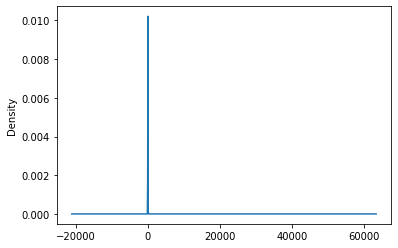

In [ ]:
# Visualize the value counts of designation
designation_counts.plot.density()

In [ ]:
# Replace the designation values for binning

# Determine which values to replace if counts are less than X
replace_designation = list(designation_counts[designation_counts < 100].index)

# Replace in dataframe
for i in replace_designation:
  rescaledData_pd.designation = rescaledData_pd.designation.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.designation.value_counts()

Other                   82649
N/A                     42304
Reserve                  2704
Reserva                  1755
Estate                   1561
Riserva                   607
Brut                      556
Crianza                   494
Estate Grown              448
Estate Bottled            395
Dry                       364
Old Vine                  330
Gran Reserva              319
Brut Rosé                 227
Bien Nacido Vineyard      195
Extra Dry                 193
Vieilles Vignes           177
Rosé                      171
Late Harvest              161
Unoaked                   156
Barrel Select             145
Grand Reserve             138
Réserve                   137
Single Vineyard           137
Old Vines                 127
Estate Reserve            121
Late Bottled Vintage      118
Classic                   115
Tinto                     112
Vintage                   103
Special Reserve           102
Kosher                    101
Name: designation, dtype: int64

In [ ]:
# Look at the province value counts for binning
province_counts = rescaledData_pd.province.value_counts()
province_counts.tail(400)

Dão                                                                              219
Cachapoal Valley                                                                 214
Limarí Valley                                                                    202
Andalucia                                                                        194
Aconcagua Valley                                                                 194
                                                                                ... 
Limnos                                                                             1
 sweet beet                                                                        1
Cape South Coast                                                                   1
Vino da Tavola della Svizzera Italiana                                             1
 smoky flavors pop up again midpalate. Medium-sized; appropriate with food.""      1
Name: province, Length: 400, dtype: int64

In [ ]:
# Replace the province values for binning

# Determine which values to replace if counts are less than X
replace_province = list(province_counts[province_counts < 500].index)

# Replace in dataframe
for i in replace_province:
  rescaledData_pd.province = rescaledData_pd.province.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.province.value_counts()

California              44342
Other                   16138
Washington               9682
Tuscany                  5961
Northern Spain           4823
Mendoza Province         4706
Oregon                   4571
Burgundy                 3340
Veneto                   3103
South Australia          2949
Piedmont                 2908
Bordeaux                 2658
New York                 2413
Sicily & Sardinia        2031
Northeastern Italy       1851
Marlborough              1595
Loire Valley             1391
Alsace                   1359
Catalonia                1331
Southwest France         1318
Central Italy            1257
Rhône Valley             1231
Colchagua Valley         1192
Southern Italy           1167
Champagne                1089
Languedoc-Roussillon     1023
Maipo Valley              888
Douro                     859
Provence                  828
Casablanca Valley         773
Mosel                     760
Central Spain             743
Alentejano                700
Stellenbos

In [ ]:
# Look at the region_1 counts for binning
region_counts = rescaledData_pd.region_1.value_counts()
region_counts.tail(1000)

Gaillac                                  83
Chianti Rufina                           83
Calistoga                                82
Valpolicella Classico Superiore          82
Valdepeñas                               82
                                         ..
Clos de Tart                              1
Gard                                      1
Côtes du Roussillon Villages Tautavel     1
Strevi                                    1
Erbaluce di Caluso                        1
Name: region_1, Length: 1000, dtype: int64

In [ ]:
# Replace the region values for binning

# Determine which values to replace if counts are less than X
replace_region = list(region_counts[region_counts < 500].index)

# Replace in dataframe
for i in replace_region:
  rescaledData_pd.region_1 = rescaledData_pd.region_1.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.region_1.value_counts()

Other                                  49452
N/A                                    22830
Napa Valley                             6187
Columbia Valley (WA)                    4940
Mendoza                                 3556
Russian River Valley                    3537
California                              3458
Paso Robles                             3039
Willamette Valley                       2085
Rioja                                   1884
Sonoma County                           1852
Toscana                                 1660
Sonoma Coast                            1473
Carneros                                1456
Dry Creek Valley                        1396
Finger Lakes                            1365
Sicilia                                 1364
Santa Barbara County                    1313
Brunello di Montalcino                  1305
Alsace                                  1261
Walla Walla Valley (WA)                 1207
Yakima Valley                           1157
Alexander 

In [ ]:
# Look at the variety counts for binning
variety_counts = rescaledData_pd.variety.value_counts()
variety_counts.tail(80)

Rufete              1
Sauvignon Musqué    1
Colorino            1
Cabernet Moravia    1
Carnelian           1
                   ..
Syrah-Malbec        1
Albarossa           1
Groppello           1
Altesse             1
Carignan-Syrah      1
Name: variety, Length: 80, dtype: int64

In [ ]:
# Replace the variety values for binning

# Determine which values to replace if counts are less than X
replace_variety = list(variety_counts[variety_counts < 1000].index)

# Replace in dataframe
for i in replace_variety:
  rescaledData_pd.variety = rescaledData_pd.variety.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.variety.value_counts()

Other                            28078
Chardonnay                       13773
Pinot Noir                       13622
Cabernet Sauvignon               12662
Red Blend                         9377
Sauvignon Blanc                   6054
Syrah                             5667
Riesling                          5210
Merlot                            4985
Bordeaux-style Red Blend          4544
Zinfandel                         3792
Malbec                            3085
Sangiovese                        2879
White Blend                       2552
Tempranillo                       2525
Rosé                              2461
Shiraz                            1941
Sparkling Blend                   1818
Portuguese Red                    1811
Nebbiolo                          1528
Rhône-style Red Blend             1455
Cabernet Franc                    1310
Corvina, Rondinella, Molinara     1292
Pinot Gris                        1275
Pinot Grigio                      1268
Viognier                 

In [ ]:
# Look at the winery counts for binning
winery_counts = rescaledData_pd.winery.value_counts()
winery_counts.tail(10000)

Barão de Vilar      9
Lammershoek         9
Château K           9
Toasted Head        9
Chateau de Pizay    9
                   ..
Blue Reef           1
Château Piron       1
Münzenrieder        1
Casa Viva           1
Unparalleled        1
Name: winery, Length: 10000, dtype: int64

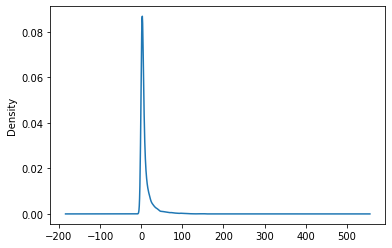

In [ ]:
# Visualize the value counts of winery
winery_counts.plot.density()

In [ ]:
# Replace the winery values for binning

# Determine which values to replace if counts are less than X
replace_winery = list(winery_counts[winery_counts < 150].index)

# Replace in dataframe
for i in replace_winery:
  rescaledData_pd.winery = rescaledData_pd.winery.replace(i, "Other")

# Check to make sure binning was successful
rescaledData_pd.winery.value_counts()

Other                    133423
Williams Selyem             371
Testarossa                  274
DFJ Vinhos                  249
Chateau Ste. Michelle       225
Columbia Crest              216
Kendall-Jackson             215
Concha y Toro               214
Trapiche                    201
Bouchard Père & Fils        192
De Loach                    189
Joseph Drouhin              185
Kenwood                     182
Cameron Hughes              172
D'Arenberg                  153
Morgan                      153
Louis Latour                153
Dry Creek Vineyard          153
Robert Mondavi              151
Concannon                   151
Name: winery, dtype: int64

In [ ]:
# Check successful binning before export
rescaledData_pd.head()

,_c0,country,description,designation,points,price,province,region_1,variety,winery,tokens,filtered_tokens,features
0,0,US,This tremendous 100% varietal wine hails from ...,Other,96,235.0,California,Napa Valley,Cabernet Sauvignon,Other,60,36,"(262144,[2701,16004,23236,28401,33079,39068,45..."
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Other,96,110.0,Northern Spain,Other,Other,Other,51,31,"(262144,[11481,33140,41643,46758,55709,59455,6..."
2,2,US,Mac Watson honors the memory of a wine once ma...,Other,96,90.0,California,Other,Sauvignon Blanc,Other,47,30,"(262144,[10077,26468,32151,49402,61157,64289,7..."
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Other,62,43,"(262144,[1546,4238,13171,15324,16356,25381,331..."
4,4,France,"This is the top wine from La Bégude, named aft...",Other,95,66.0,Provence,Other,Other,Other,66,37,"(262144,[1546,17161,18176,31536,33140,48479,49..."


In [ ]:
'''
# Write binned_df to s3
dataframe = rescaledData_pd
filename = "winemag-data_binned.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)

# Make file public from s3 loading into next cell
'''

'\n# Write binned_df to s3\ndataframe = rescaledData_pd\nfilename = "winemag-data_binned.csv"\nDESTINATION = \'whats-in-a-bottle\'\n\n_write_dataframe_to_csv_on_s3(dataframe, filename)\n\n# Make file public from s3 loading into next cell\n'

In [ ]:
'''
# Save the binned dataframe to GDrive
rescaledData_pd.to_csv('winemag-data_binned.csv', index=False)

# Path = "drive/My Drive/destination folder"
!cp winemag-data_binned.csv "drive/My Drive/Bootcamp/Whats_In_A_Bottle"
'''

'\n# Save the binned dataframe to GDrive\nrescaledData_pd.to_csv(\'winemag-data_binned.csv\', index=False)\n\n# Path = "drive/My Drive/destination folder"\n!cp winemag-data_binned.csv "drive/My Drive/Bootcamp/Whats_In_A_Bottle"\n'

#### *Additional Cleaning Step: Remove string values from the price and points column*

When changing the column types of price and points, an error was thrown indicating that some values in these columns were non numeric. 

Checkpoint (Binned DF)

In [ ]:
# Load the binned dataframe from s3
# Read in data from S3 Buckets
url3 ="https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_binned.csv"
spark.sparkContext.addFile(url3)
binned_df = spark.read.csv(SparkFiles.get("winemag-data_binned.csv"), sep=",", header=True)
binned_df.show()

+---+-------+--------------------+-----------+------+-----+------------------+-----------------+------------------+------+------+---------------+--------------------+
|_c0|country|         description|designation|points|price|          province|         region_1|           variety|winery|tokens|filtered_tokens|            features|
+---+-------+--------------------+-----------+------+-----+------------------+-----------------+------------------+------+------+---------------+--------------------+
|  0|     US|This tremendous 1...|      Other|    96|235.0|        California|      Napa Valley|Cabernet Sauvignon| Other|    60|             36|(262144,[2701,160...|
|  1|  Spain|Ripe aromas of fi...|      Other|    96|110.0|    Northern Spain|            Other|             Other| Other|    51|             31|(262144,[11481,33...|
|  2|     US|Mac Watson honors...|      Other|    96| 90.0|        California|            Other|   Sauvignon Blanc| Other|    47|             30|(262144,[10077,26...

In [ ]:
# Check column datatypes
binned_df = binned_df.toPandas()
binned_df.head()

,_c0,country,description,designation,points,price,province,region_1,variety,winery,tokens,filtered_tokens,features
0,0,US,This tremendous 100% varietal wine hails from ...,Other,96,235.0,California,Napa Valley,Cabernet Sauvignon,Other,60,36,"(262144,[2701,16004,23236,28401,33079,39068,45..."
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Other,96,110.0,Northern Spain,Other,Other,Other,51,31,"(262144,[11481,33140,41643,46758,55709,59455,6..."
2,2,US,Mac Watson honors the memory of a wine once ma...,Other,96,90.0,California,Other,Sauvignon Blanc,Other,47,30,"(262144,[10077,26468,32151,49402,61157,64289,7..."
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Other,62,43,"(262144,[1546,4238,13171,15324,16356,25381,331..."
4,4,France,"This is the top wine from La Bégude, named aft...",Other,95,66.0,Provence,Other,Other,Other,66,37,"(262144,[1546,17161,18176,31536,33140,48479,49..."


In [ ]:
# Check the data types
binned_df.dtypes

_c0                object
country            object
description        object
designation        object
points             object
price              object
province           object
region_1           object
variety            object
winery             object
tokens             object
filtered_tokens    object
features           object
dtype: object

In [ ]:
# Filter out non-numeric rows in c0 column
binned_df = binned_df[binned_df._c0.apply(lambda x: x.isdigit())]
# Convert _c0 to int
binned_df['_c0'] = binned_df['_c0'].astype('int')

len(binned_df)

137221

In [ ]:
# Convert tokens, filtered_tokens, and features to numeric
binned_df[['tokens','filtered_tokens']] = binned_df[['tokens','filtered_tokens']].apply(pd.to_numeric, errors = 'coerce')
binned_df.dtypes

_c0                  int64
country             object
description         object
designation         object
points              object
price               object
province            object
region_1            object
variety             object
winery              object
tokens             float64
filtered_tokens    float64
features            object
dtype: object

In [ ]:
# Look at the price counts
price_counts = binned_df.price.value_counts()
price_counts.tail(10)

1300.0                                                              1
266.0                                                               1
426.0                                                               1
217.0                                                               1
231.0                                                               1
1000.0                                                              1
323.0                                                               1
580.0                                                               1
520.0                                                               1
""""""""""" as Australians like to say. Scents of raspberries"""    1
Name: price, dtype: int64

In [ ]:
# Replace strings with digits in price column
binned_df['price'] = pd.to_numeric(binned_df['price'], errors = 'coerce')
binned_df.price.dropna(inplace = True, axis=0)
print(binned_df['price'])

0         235.0
1         110.0
2          90.0
3          65.0
4          66.0
          ...  
137217     20.0
137218     27.0
137219     20.0
137220     52.0
137221     15.0
Name: price, Length: 137221, dtype: float64


In [ ]:
# Check to make sure strings in price column were replaced
updated_price_counts = binned_df.price.value_counts()
updated_price_counts.tail(10)

415.0    1
271.0    1
335.0    1
398.0    1
319.0    1
740.0    1
545.0    1
351.0    1
698.0    1
588.0    1
Name: price, dtype: int64

In [ ]:
# Look at the points counts
points_counts = binned_df.points.value_counts()
points_counts.tail(10)

 which dates back to the 1860s and which the winery says may be the oldest producing Zin vineyard in the world. The wine is classic old-vine                       1
 and who should care? Deep black fruit with perfect oak makes for the ultimate in integration. A long cocoa and spice finish closes the show. Wonderfully sweet    1
 this wine is still quite tannic with good structure to age. The Sonoma-based Robledo family is making more and more wine from Red Hills                           1
 concentrated aromas of tangerine                                                                                                                                  1
 spicy finish                                                                                                                                                      1
" it' would be a good base for """"""""Champagne"""""""" cocktails."""""""                                                                                         1
 and perha

In [ ]:
# Replace strings with digits in points column
binned_df['points'] = pd.to_numeric(binned_df['points'], errors = 'coerce')
binned_df.points.dropna(inplace = True, axis=0)
print(binned_df['points'])

0         96.0
1         96.0
2         96.0
3         96.0
4         95.0
          ... 
137217    91.0
137218    91.0
137219    91.0
137220    90.0
137221    90.0
Name: points, Length: 137221, dtype: float64


In [ ]:
binned_df.head()

,_c0,country,description,designation,points,price,province,region_1,variety,winery,tokens,filtered_tokens,features
0,0,US,This tremendous 100% varietal wine hails from ...,Other,96.0,235.0,California,Napa Valley,Cabernet Sauvignon,Other,60.0,36.0,"(262144,[2701,16004,23236,28401,33079,39068,45..."
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Other,96.0,110.0,Northern Spain,Other,Other,Other,51.0,31.0,"(262144,[11481,33140,41643,46758,55709,59455,6..."
2,2,US,Mac Watson honors the memory of a wine once ma...,Other,96.0,90.0,California,Other,Sauvignon Blanc,Other,47.0,30.0,"(262144,[10077,26468,32151,49402,61157,64289,7..."
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96.0,65.0,Oregon,Willamette Valley,Pinot Noir,Other,62.0,43.0,"(262144,[1546,4238,13171,15324,16356,25381,331..."
4,4,France,"This is the top wine from La Bégude, named aft...",Other,95.0,66.0,Provence,Other,Other,Other,66.0,37.0,"(262144,[1546,17161,18176,31536,33140,48479,49..."


In [ ]:
'''
# Write binned_df to s3
dataframe = binned_df
filename = "winemag-data_cleaned_ReadyToEncode.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)

# Make file public from s3 loading into next cell
'''

'\n# Write binned_df to s3\ndataframe = binned_df\nfilename = "winemag-data_cleaned_ReadyToEncode.csv"\nDESTINATION = \'whats-in-a-bottle\'\n\n_write_dataframe_to_csv_on_s3(dataframe, filename)\n\n# Make file public from s3 loading into next cell\n'

### **5. Encode the categorical columns with the Label Encoder**

Convert the features column to a list of lists that can generate a new DF that has a separate column for each number in the list of features

In [ ]:
# Convert the features column to a single list per row
arrays = binned_df['features'].tolist()
#print(arrays)
new_array = []
new_list = {}

for index,row in binned_df.iterrows():
  #if index > 3:
    #break
  new_array = []
  feature = row['features']
  feats = feature.split(',')
  #print(feats)
  for val in feats:
    #print(val)
    vals = val.split(',')
    for val2 in vals:
      vals2 = val2.split(',')
      for val3 in vals2:
        val3 = val3.strip('([])')
        try:
          new_array.append(float(val3))
        except Exception:
          pass
  #print(len(new_array))
  new_list[index]=new_array
  

print(new_list[2])

new_array = np.array(new_list).reshape(1,-1)
#print(new_array)

[262144.0, 10077.0, 26468.0, 32151.0, 49402.0, 61157.0, 64289.0, 76272.0, 88398.0, 99749.0, 119775.0, 123974.0, 140784.0, 153612.0, 156125.0, 171516.0, 172455.0, 172814.0, 174799.0, 188828.0, 203214.0, 215060.0, 217441.0, 223329.0, 225667.0, 229305.0, 238819.0, 245426.0, 251052.0, 256740.0, 261845.0, 9.26441326124659, 10.730750330040017, 10.730750330040017, 3.9031210955371645, 9.632138041371906, 4.824480628995267, 7.485557196854443, 7.422643371443874, 4.046138602372089, 4.034539466528737, 4.791456655260944, 3.1991979486327278, 3.6440123955294395, 6.169880402948506, 9.121312417605916, 7.00908105310309, 2.656724113915955, 7.498629278421795, 6.336301175367578, 3.204571416693871, 5.647277711991495, 8.784840180984704, 1.0707791186260356, 5.132328371041642, 2.817351241671715, 3.421314874552687, 8.833630345154136, 4.376960167484488, 3.4941710352749236, 6.201741505017489]


In [ ]:
# Create a dataframe from the new list dictionary
features_df = pd.DataFrame.from_dict(new_list, orient='index')
features_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134
41794,262144.0,4185.0,10044.0,10049.0,16620.0,25882.0,45315.0,86577.0,113432.0,155288.0,189720.0,207327.0,212413.0,221693.000000,226718.000000,259966.000000,6.859549,2.541043,3.686717,5.186876,3.985906,7.244395,3.101098,2.329043,1.956489,6.773117,5.968576,2.201629,6.653213,6.413262,8.996149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7056,262144.0,10044.0,12702.0,16704.0,33140.0,55709.0,58534.0,97880.0,102682.0,153504.0,155665.0,161081.0,162976.0,166936.000000,172196.000000,186925.000000,190266.000000,197010.000000,205896.000000,223329.000000,2.541043,3.723451,3.315575,1.924876,2.081360,3.043212,3.980039,3.483907,8.366018,3.347797,3.359680,3.034841,3.521903,3.491057,2.934692,2.761739,8.533526,7.511875,3.212337,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75784,262144.0,1765.0,25582.0,25692.0,28808.0,69650.0,84221.0,127005.0,154193.0,205687.0,218214.0,223329.0,235089.0,6.587616,4.734298,6.112335,3.639563,2.432626,2.793971,9.883452,4.304262,4.817247,2.442132,1.070779,4.451604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114422,262144.0,4765.0,5847.0,41333.0,46758.0,50554.0,55687.0,57058.0,77524.0,79709.0,82806.0,86617.0,87623.0,113456.000000,127501.000000,134272.000000,135130.000000,143299.000000,155288.000000,161509.000000,175434.000000,186977.000000,208258.000000,222465.000000,223329.000000,243643.000000,259602.000000,5.791492,3.816351,5.957245,1.638743,2.421484,5.103129,5.065478,7.410522,3.325660,5.622787,3.681785,2.504534,5.765577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115490,262144.0,31925.0,46758.0,78495.0,120069.0,123935.0,125169.0,129299.0,150278.0,165226.0,192648.0,194358.0,220452.0,223329.000000,229543.000000,231992.000000,237775.000000,251391.000000,6.440291,1.638743,2.007411,6.261018,9.749921,6.614427,6.145783,5.827948,9.632138,4.166895,8.651309,7.375015,1.070779,8.332855,7.156534,4.913639,11.136215,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91014,262144.0,10564.0,12531.0,57058.0,58227.0,72082.0,77506.0,134272.0,143501.0,146405.0,153612.0,181885.0,185931.0,212761.000000,223329.000000,256565.000000,2.212757,2.643520,5.065478,3.766930,7.138015,2.903642,1.130487,4.543171,6.369777,3.644012,4.656171,6.477504,4.871865,1.070779,3.315977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63344,262144.0,12109.0,14079.0,33140.0,36225.0,39286.0,49402.0,50415.0,55209.0,55709.0,58227.0,88398.0,95607.0,101336.000000,101940.000000,105672.000000,136071.000000,138954.000000,148921.000000,151150.000000,156550.000000,185559.000000,190120.000000,195642.000000,203802.000000,206312.000000,210802.000000,224718.000000,248069.000000,254027.000000,6.664577,5.897117,1.924876,3.774522,4.078748,3.903121,8.533526,8.022700,2.081360,3.766930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33782,262144.0,5847.0,151

In [ ]:
# Drop column 0 since it's all the same number
features_df = features_df.drop([0],axis=1)

In [ ]:
# Check length of features_df
len(features_df)

137221

In [ ]:
# Check the length of the binned_df
len(binned_df)

137221

In [ ]:
# Merge the dataframes
merged_df = pd.merge(binned_df, features_df, left_index=True, right_index=True)
merged_df = merged_df.drop(['description'], axis=1)
merged_df.head(5)

,_c0,country,designation,points,price,province,region_1,variety,winery,tokens,filtered_tokens,features,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,...,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134
0,0,US,Other,96.0,235.0,California,Napa Valley,Cabernet Sauvignon,Other,60.0,36.0,"(262144,[2701,16004,23236,28401,33079,39068,45...",2701.0,16004.0,23236.0,28401.0,33079.0,39068.0,45330.0,46582.0,63420.0,66669.0,75898.0,76106.0,87005.0,96005.0,100312.0,125177.0,125919.0,135627.0,141911.0,143299.0,146696.0,158571.0,158931.0,163760.0,164837.0,171917.0,185760.0,200144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Spain,Other,96.0,110.0,Northern Spain,Other,Other,Other,51.0,31.0,"(262144,[11481,33140,41643,46758,55709,59455,6...",11481.0,33140.0,41643.0,46758.0,55709.0,59455.0,69650.0,79653.0,104662.0,106432.0,119670.0,134272.0,143776.0,149300.0,149583.0,154828.0,160195.0,161469.0,168341.0,172530.0,186037.0,190120.0,206577.0,208892.0,212295.0,213835.0,216086.0,217078.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,US,Other,96.0,90.0,California,Other,Sauvignon Blanc,Other,47.0,30.0,"(262144,[10077,26468,32151,49402,61157,64289,7...",10077.0,26468.0,32151.0,49402.0,61157.0,64289.0,76272.0,88398.0,99749.0,119775.0,123974.0,140784.0,153612.0,156125.0,171516.0,172455.0,172814.0,174799.0,188828.0,203214.0,215060.0,217441.0,223329.0,225667.0,229305.0,238819.0,245426.0,251052.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,US,Reserve,96.0,65.0,Oregon,Willamette Valley,Pinot Noir,Other,62.0,43.0,"(262144,[1546,4238,13171,15324,16356,25381,331...",1546.0,4238.0,13171.0,15324.0,16356.0,25381.0,33140.0,46758.0,56257.0,67144.0,69650.0,78329.0,84417.0,89833.0,90804.0,93436.0,100762.0,105672.0,123598.0,125919.0,127791.0,134272.0,143299.0,145689.0,154213.0,154828.0,159212.0,170657.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,France,Other,95.0,66.0,Provence,Other,Other,Other,66.0,37.0,"(262144,[1546,17161,18176,31536,33140,48479,49...",1546.0,17161.0,18176.0,31536.0,33140.0,48479.0,49526.0,65848.0,88378.0,90392.0,93114.0,103473.0,115192.0,119201.0,137039.0,140762.0,140784.0,148880.0,160897.0,179287.0,198725.0,208852.0,212413.0,213305.0,221427.0,222710.0,223329.0,226521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop the features column
merged_df = merged_df.drop(['features'], axis=1)
merged_df.dtypes

_c0              int64
country         object
designation     object
points         float64
price          float64
                ...   
130            float64
131            float64
132            float64
133            float64
134            float64
Length: 145, dtype: object

#### 5.1 Label Encode Category Columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categories = merged_df.dtypes[merged_df.dtypes == 'object'].index.tolist()

le_df = merged_df[categories]

le_df = le_df.apply(le.fit_transform)
le_df.head()

,country,designation,province,region_1,variety,winery
0,12,20,6,24,2,15
1,11,20,26,26,9,15
2,12,20,6,26,19,15
3,12,22,27,46,12,15
4,4,20,31,26,9,15


#### 5.2 Track which labels correspond to original values:

In [ ]:
# Print out the encoded values

#var = list(le.classes_)
#list(le.classes_)

country = list(merged_df['country'].unique())
designation = list(merged_df['designation'].unique())
province = list(merged_df['province'].unique())
region = list(merged_df['region_1'].unique())
variety = list(merged_df['variety'].unique())
winery = list(merged_df['winery'].unique())

#print(type(var))

country_num = list(le.fit_transform(country))
designation_num = list(le.fit_transform(designation))
province_num = list(le.fit_transform(province))
region_num = list(le.fit_transform(region))
variety_num = list(le.fit_transform(variety))
winery_num = list(le.fit_transform(winery))

print(designation)
print(designation_num)
print(len(region))

['Other', 'Reserve', 'Riserva', 'N/A', 'Estate Grown', 'Barrel Select', 'Reserva', 'Estate', 'Crianza', 'Estate Reserve', 'Réserve', 'Estate Bottled', 'Brut Rosé', 'Dry', 'Vieilles Vignes', 'Unoaked', 'Brut', 'Bien Nacido Vineyard', 'Late Harvest', 'Special Reserve', 'Rosé', 'Single Vineyard', 'Gran Reserva', 'Vintage', 'Classic', 'Tinto', 'Late Bottled Vintage', 'Old Vine', 'Grand Reserve', 'Old Vines', 'Kosher', 'Extra Dry']
[20, 22, 23, 17, 9, 0, 21, 7, 5, 10, 25, 8, 3, 6, 30, 29, 2, 1, 16, 27, 24, 26, 12, 31, 4, 28, 15, 18, 13, 19, 14, 11]
48


In [ ]:
# Create a country df for encoded labels
country_df = pd.DataFrame(list(zip(country_num, country)),
               columns =['number','country'])
country_df = country_df.sort_values(by=['number'])

# Create a designation df for encoded labels
designation_df = pd.DataFrame(list(zip(designation_num, designation)),
               columns =['number','designation'])
designation_df = designation_df.sort_values(by=['number'])

# Create a province df for encoded labels
province_df = pd.DataFrame(list(zip(province_num, province)),
               columns =['number','province'])
province_df = province_df.sort_values(by=['number'])

# Create a region df for encoded labels
region_df = pd.DataFrame(list(zip(region_num, region)),
               columns =['number','region'])
region_df = region_df.sort_values(by=['number'])

# Create a variety df for encoded labels
variety_df = pd.DataFrame(list(zip(variety_num, variety)),
               columns =['number','variety'])
variety_df = variety_df.sort_values(by=['number'])

# Create a winery df for encoded labels
winery_df = pd.DataFrame(list(zip(winery_num, winery)),
               columns =['number','winery'])
winery_df = winery_df.sort_values(by=['number'])

#province_df.head()

In [ ]:
# Merge the dataframe
from functools import reduce

dfs = [country_df, designation_df, province_df, region_df, variety_df, winery_df]
labels = reduce(lambda left,right: pd.merge(left,right,on='number',how='outer'), dfs)

labels.head()

,number,country,designation,province,region,variety,winery
0,0,Argentina,Barrel Select,Alentejano,Alexander Valley,Bordeaux-style Red Blend,Bouchard Père & Fils
1,1,Australia,Bien Nacido Vineyard,Alsace,Alsace,Cabernet Franc,Cameron Hughes
2,2,Austria,Brut,Australia Other,Amarone della Valpolicella Classico,Cabernet Sauvignon,Chateau Ste. Michelle
3,3,Chile,Brut Rosé,Bordeaux,Anderson Valley,Champagne Blend,Columbia Crest
4,4,France,Classic,Burgenland,Barolo,Chardonnay,Concannon


In [ ]:
'''
# Write labels to s3
dataframe = labels
filename = "winemag-data_encodingLabels.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)
'''

'\n# Write labels to s3\ndataframe = labels\nfilename = "winemag-data_encodingLabels.csv"\nDESTINATION = \'whats-in-a-bottle\'\n\n_write_dataframe_to_csv_on_s3(dataframe, filename)\n'

In [ ]:
# Drop the category columns from merged_df
encoded_df = merged_df.drop(categories, axis=1)
encoded_df.head()

# Merge le encoded features and drop the originals
cleaned_df = le_df.merge(encoded_df, left_index=True, right_index=True)
cleaned_df.head()

,country,designation,province,region_1,variety,winery,_c0,points,price,tokens,filtered_tokens,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134
0,12,20,6,24,2,15,0,96.0,235.0,60.0,36.0,2701.0,16004.0,23236.0,28401.0,33079.0,39068.0,45330.0,46582.0,63420.0,66669.0,75898.0,76106.0,87005.0,96005.0,100312.0,125177.0,125919.0,135627.0,141911.0,143299.0,146696.0,158571.0,158931.0,163760.0,164837.0,171917.0,185760.0,200144.0,203214.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,20,26,26,9,15,1,96.0,110.0,51.0,31.0,11481.0,33140.0,41643.0,46758.0,55709.0,59455.0,69650.0,79653.0,104662.0,106432.0,119670.0,134272.0,143776.0,149300.0,149583.0,154828.0,160195.0,161469.0,168341.0,172530.0,186037.0,190120.0,206577.0,208892.0,212295.0,213835.0,216086.0,217078.0,219145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,20,6,26,19,15,2,96.0,90.0,47.0,30.0,10077.0,26468.0,32151.0,49402.0,61157.0,64289.0,76272.0,88398.0,99749.0,119775.0,123974.0,140784.0,153612.0,156125.0,171516.0,172455.0,172814.0,174799.0,188828.0,203214.0,215060.0,217441.0,223329.0,225667.0,229305.0,238819.0,245426.0,251052.0,256740.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,22,27,46,12,15,3,96.0,65.0,62.0,43.0,1546.0,4238.0,13171.0,15324.0,16356.0,25381.0,33140.0,46758.0,56257.0,67144.0,69650.0,78329.0,84417.0,89833.0,90804.0,93436.0,100762.0,105672.0,123598.0,125919.0,127791.0,134272.0,143299.0,145689.0,154213.0,154828.0,159212.0,170657.0,176028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20,31,26,9,15,4,95.0,66.0,66.0,37.0,1546.0,17161.0,18176.0,31536.0,33140.0,48479.0,49526.0,65848.0,88378.0,90392.0,93114.0,103473.0,115192.0,119201.0,137039.0,140762.0,140784.0,148880.0,160897.0,179287.0,198725.0,208852.0,212413.0,213305.0,221427.0,222710.0,223329.0,226521.0,233705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# use ix to reorder the columns
cleaned_df = cleaned_df[ ['price'] + [ col for col in cleaned_df.columns if col != 'price' ] ]
cleaned_df = cleaned_df[ ['points'] + [ col for col in cleaned_df.columns if col != 'points' ] ]
cleaned_df = cleaned_df[ ['_c0'] + [ col for col in cleaned_df.columns if col != '_c0' ] ]

# Rename the _c0 as primary key
#cleaned_df = cleaned_df.rename(columns={'_c0':'primary_key'})

# Keep only the top ten words columns
cleaned_df = cleaned_df.iloc[: , :-124]
cleaned_df.head(5)

,_c0,points,price,country,designation,province,region_1,variety,winery,tokens,filtered_tokens,1,2,3,4,5,6,7,8,9,10
0,0,96.0,235.0,12,20,6,24,2,15,60.0,36.0,2701.0,16004.0,23236.0,28401.0,33079.0,39068.0,45330.0,46582.0,63420.0,66669.0
1,1,96.0,110.0,11,20,26,26,9,15,51.0,31.0,11481.0,33140.0,41643.0,46758.0,55709.0,59455.0,69650.0,79653.0,104662.0,106432.0
2,2,96.0,90.0,12,20,6,26,19,15,47.0,30.0,10077.0,26468.0,32151.0,49402.0,61157.0,64289.0,76272.0,88398.0,99749.0,119775.0
3,3,96.0,65.0,12,22,27,46,12,15,62.0,43.0,1546.0,4238.0,13171.0,15324.0,16356.0,25381.0,33140.0,46758.0,56257.0,67144.0
4,4,95.0,66.0,4,20,31,26,9,15,66.0,37.0,1546.0,17161.0,18176.0,31536.0,33140.0,48479.0,49526.0,65848.0,88378.0,90392.0


### **6. Check the final cleaned dataframe for missing data or null values**

In [ ]:
# Check the length of the cleaned df
cleaned_df.isnull().sum()

_c0                 0
points             27
price              25
country             0
designation         0
province            0
region_1            0
variety             0
winery              0
tokens              5
filtered_tokens     3
1                  12
2                  12
3                  13
4                  13
5                  19
6                  19
7                  32
8                  32
9                  44
10                 44
dtype: int64

In [ ]:
# Drop the null values
cleaned_df = cleaned_df.dropna(axis=0)
cleaned_df.isnull().sum()

_c0                0
points             0
price              0
country            0
designation        0
province           0
region_1           0
variety            0
winery             0
tokens             0
filtered_tokens    0
1                  0
2                  0
3                  0
4                  0
5                  0
6                  0
7                  0
8                  0
9                  0
10                 0
dtype: int64

In [ ]:
'''
# Write binned_df to s3
dataframe = cleaned_df
filename = "winemag-data_cleaned_primaryKey.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)
'''

'\n# Write binned_df to s3\ndataframe = cleaned_df\nfilename = "winemag-data_cleaned_primaryKey.csv"\nDESTINATION = \'whats-in-a-bottle\'\n\n_write_dataframe_to_csv_on_s3(dataframe, filename)\n'

Checkpoint (cleaned data)

In [ ]:
# Load the binned dataframe from s3
# Read in data from S3 Buckets
url4 ="https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_cleaned_primaryKey.csv"
spark.sparkContext.addFile(url4)
cleaned_df = spark.read.csv(SparkFiles.get("winemag-data_cleaned_primaryKey.csv"), sep=",", header=True)
cleaned_df.show(50)

+---+------+-----+-------+-----------+--------+--------+-------+------+------+---------------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+
|_c0|points|price|country|designation|province|region_1|variety|winery|tokens|filtered_tokens|      1|      2|      3|      4|       5|       6|       7|       8|       9|      10|
+---+------+-----+-------+-----------+--------+--------+-------+------+------+---------------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+
|  0|  96.0|235.0|     12|         20|       6|      24|      2|    15|  60.0|           36.0| 2701.0|16004.0|23236.0|28401.0| 33079.0| 39068.0| 45330.0| 46582.0| 63420.0| 66669.0|
|  1|  96.0|110.0|     11|         20|      26|      26|      9|    15|  51.0|           31.0|11481.0|33140.0|41643.0|46758.0| 55709.0| 59455.0| 69650.0| 79653.0|104662.0|106432.0|
|  2|  96.0| 90.0|     12|         20|       6|      26|     19|    15|  47.0|           30.0|1

### **7. Export the cleaned data to the database (pgAdmin)**

In [ ]:
# Export cleaned-data to pgAdmin
print(f'Writing {cleaned_df.count()} rows')
cleaned_df.write.jdbc(url=jdbc_url, table='cleaned_data', mode=mode, properties=config)
print('Done')

Writing 137167 rows
Done


### **Extra:** *Create a dataframe with encoded values and corresponding labels*
We want to develop additional models to predict categorical variables (province, region, country etc) using the other columns in the dataset. To do so, we will merge the dataframe that containst the original columns with the categorical values with the cleaned dataframe that's been encoded.

In [ ]:
print(len(merged_df))
print(len(cleaned_df))

In [ ]:
# Merge le encoded features and drop the originals
withLabels = le_df.merge(merged_df, left_index=True, right_index=True)
cleaned_withLabels  = withLabels.iloc[: , :-124]

cleaned_withLabels.head()

In [ ]:
# use ix to reorder the columns
cleaned_withLabels = cleaned_withLabels[ ['price'] + [ col for col in cleaned_withLabels.columns if col != 'price' ] ]
cleaned_withLabels = cleaned_withLabels[ ['points'] + [ col for col in cleaned_withLabels.columns if col != 'points' ] ]
cleaned_withLabels = cleaned_withLabels[ ['_c0'] + [ col for col in cleaned_withLabels.columns if col != '_c0' ] ]
cleaned_withLabels.head(10)

In [ ]:
# Export cleaned_withLabels to pgAdmin
print(f'Writing {cleaned_df.count()} rows')
cleaned_df.write.jdbc(url=jdbc_url, table='cleaned_data', mode=mode, properties=config)
print('Done')

In [ ]:
'''
# Write cleaned with labels to s3
dataframe = cleaned_withLabels
filename = "winemag-data_cleaned_withLabels.csv"
DESTINATION = 'whats-in-a-bottle'

_write_dataframe_to_csv_on_s3(dataframe, filename)

# Make file public from s3 loading into next cell
'''